In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [2]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [3]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
        100 * df['R'].mean(), 100 * df['R'].median(), df['R'].std()))
    print('Volume mean: {:.5f}'.format(df['Volume'].mean()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))

### Query Selection

In [178]:
query_top = '''
    SELECT
        CusipId,
        TrdExctnDtEOM,
        Coupon,
        CASE
            WHEN RatingNum <= 10 THEN 'HY'
            WHEN RatingNum >= 11 THEN 'IG'
            ELSE NULL
        END AS RatingClass,
        Volume,
        R
    FROM
        BondReturns_topPerformers_wholeMonth
    ORDER BY
        CusipId,
        TrdExctnDtEOM
'''

# read sql
df = pd.read_sql(query_top, connection)
df.to_csv('data/output/momentum/mom-topPerformers-wholeMonth.csv', index=False)

In [179]:
# read csv
df = pd.read_csv(
    'data/output/momentum/mom-topPerformers-wholeMonth.csv', 
    dtype={
        'CusipId': 'string',
        'TrdExctnDtEOM': 'string',
        'Coupon': 'float64',
        'RatingClass': 'string',
        'Volume': 'float64',
        'R': 'float64'
    },
    parse_dates=['TrdExctnDtEOM']
)

df.columns = ['Cusip', 'Date', 'Coupon', 'RatingClass', 'Volume', 'R']

### Quantile Filtering and Outlier Visualization

In [160]:
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)
df['Year'] = df['Date'].dt.year

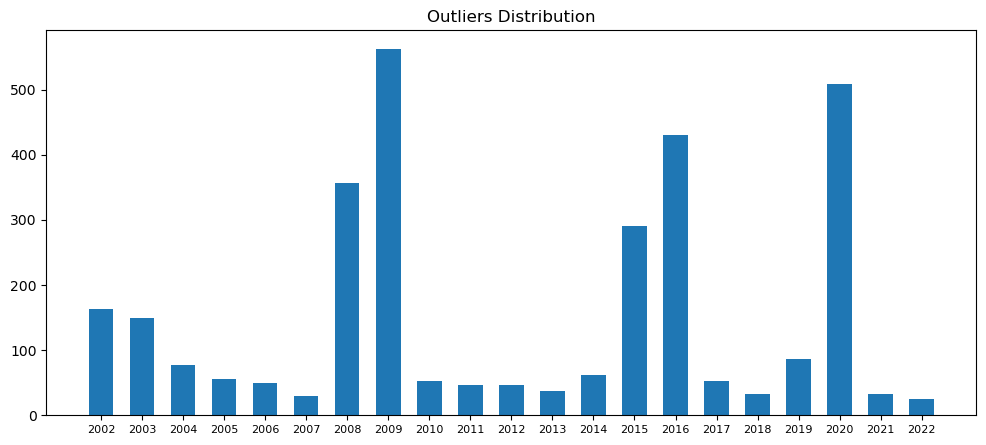

In [161]:
df_g = df.groupby('Year')['outliers'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [162]:
# filter out outliers
df['R'] = np.where(df['outliers'] == 0, df['R'], 0)

### Exploratory Analysis

In [163]:
df['Cusip'].nunique()

18443

In [182]:
# number of entries
df['RatingClass'].value_counts()

HY    325908
IG    137978
Name: RatingClass, dtype: Int64

In [183]:
# number of distinct Cusips
df.groupby('RatingClass').Cusip.nunique()

RatingClass
HY    15355
IG     4783
Name: Cusip, dtype: int64

In [141]:
# drop NR
# df = df.dropna(subset=['RatingNum'])

# number of entries
# df['MaturityBand'].value_counts(dropna=False)

In [142]:
# number of distinct Cusips
# df.groupby('MaturityBand').Cusip.nunique()

In [143]:
# df['Cusip'].nunique()

In [144]:
# filtering
# df = df[df['MaturityBand'] == 1]
# df = df[df['RatingClass'] == '1.HY']

In [145]:
get_sample_particulars(df)

Number of observations: 1,023,685
Returns: Mean: 0.02423 | Median: -0.01953 | Std returns: 0.03033
Volume mean: 4829603.67594
Coupon mean: 5.55755


### Portfolio Analysis

In [146]:
# fill NULL returns
# df['R'] = df['R'].fillna(0)

# log returns
df['logR'] = np.log(1 + df['R'])

In [147]:
J = 3 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [148]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [149]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.071411
2    -0.029285
3    -0.017551
4    -0.009793
5    -0.003167
6     0.003345
7     0.010246
8     0.018811
9     0.032318
10    0.077645
Name: CumRet, dtype: float64

In [150]:
K = 6 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2']]

port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]
port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R']]
port['Date'] = pd.to_datetime(port['Date'])

In [151]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min() + 2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

ewret = cumr_port.groupby(['Date','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [152]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,225.0,0.000369,0.023341
1,2,225.0,-0.000750,0.018737
2,3,225.0,-0.000728,0.015577
3,4,225.0,-0.000788,0.014296
4,5,225.0,-0.000802,0.013693
5,6,225.0,-0.000657,0.013750
6,7,225.0,-0.000599,0.013749
7,8,225.0,-0.000385,0.014562
8,9,225.0,-0.000114,0.015736
9,10,225.0,0.000878,0.019052


In [153]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2004-01-31,0.007381,0.006582,0.005388,0.004617,0.005511,0.005660,0.003300,0.004560,0.009812,0.019791,0.012410
2004-02-29,0.004703,0.004327,0.004426,0.005946,0.004237,0.004915,0.003930,-0.000244,-0.005923,-0.020099,-0.024802
2004-03-31,0.006842,0.001348,0.000765,0.003869,0.004206,0.002868,0.003386,0.005121,0.001640,-0.006237,-0.013079
2004-04-30,-0.007536,-0.014508,-0.019949,-0.028098,-0.029410,-0.032686,-0.031384,-0.033546,-0.030780,-0.019889,-0.012353
2004-05-31,-0.012985,-0.009495,-0.013619,-0.012660,-0.011330,-0.014003,-0.012723,-0.011408,-0.015231,-0.021506,-0.008520


In [154]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()
mom_mean

,MomR,mean
0,winners,0.000878
1,losers,0.000369
2,long_short,0.000509


In [155]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0, nan_policy='omit')).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0, nan_policy='omit')).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0, nan_policy='omit')).to_frame().T

t_losers['MomR'] = 'losers'
t_winners['MomR'] = 'winners'
t_long_short['MomR'] = 'long_short'

In [156]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR   mean t-stat p-value
0     winners  0.09%   0.69    0.49
1      losers  0.04%   0.24    0.81
2  long_short  0.05%   0.52    0.60


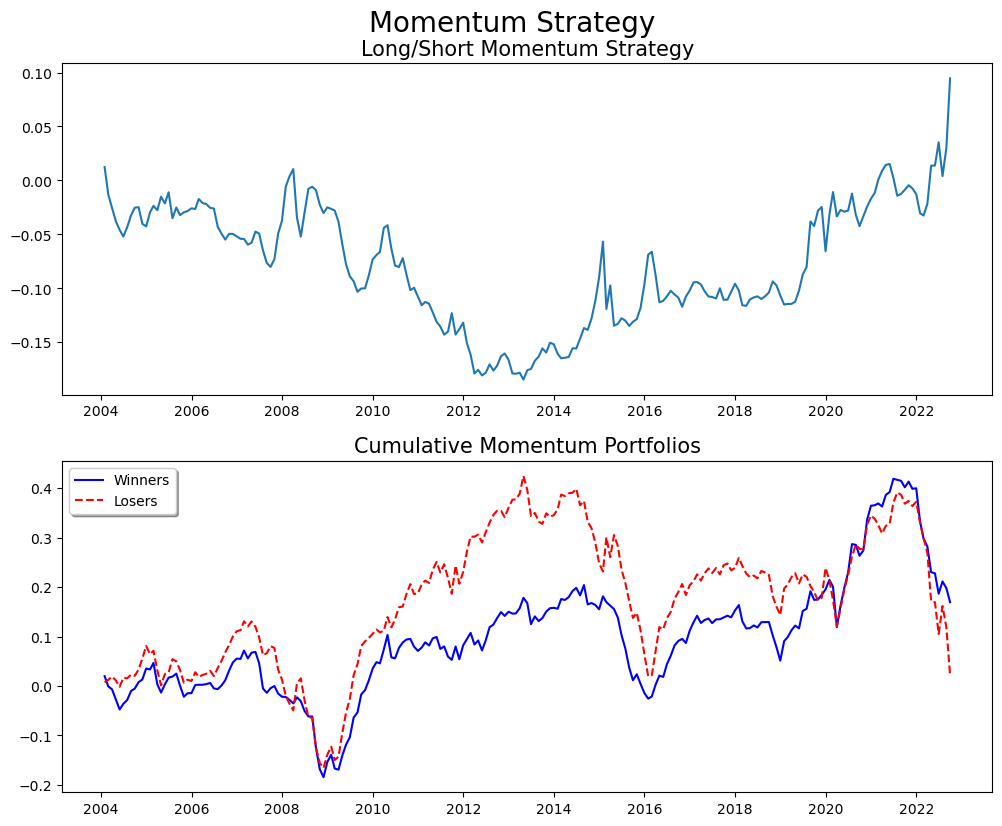

In [157]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)